# Import packages


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
import mapclassify as mc
import branca.colormap as cm
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Nepal map

## Provinces

In [2]:
# Load Nepal shape files. Downloaded from https://data.humdata.org/dataset/administrative-bounadries-of-nepal

nepal_country = gpd.read_file("UN_OCHA_Services/npl_admbnda_adm0_nd_20190430.shp")
nepal_province = gpd.read_file("UN_OCHA_Services/npl_admbnda_adm1_nd_20190430.shp")
nepal_district = gpd.read_file("UN_OCHA_Services/npl_admbnda_districts_nd_20190430.shp")
nepal_local = gpd.read_file("UN_OCHA_Services/npl_admbnda_adm2_nd_20190430.shp")


In [3]:
# Identifying some offices (in local divisions) using coordinates

# Create GeoDataFrame with points we want to locate in map

d = {'col1': ['Simra' , 
              'Dhangadi',
              'Damauli'], 
     'geometry': [Point(85.367778, 26.939722), 
                  Point(80.6, 28.683333),
                  Point(84.268806, 27.972624)]}

gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")

# Merge with map with regions

result = gpd.sjoin(gdf, nepal_local, how="left", op='intersects')

result.head(3)


,col1,geometry,index_right,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,ValidTo,DIST_EN,DIST_PCODE
0,Simra,POINT (85.36778 26.93972),248,0.339580,0.004493,Gadhimai,NP0232309,None,None,None,2,NP02,Nepal,NP,2017-11-15,2019-04-30,None,Rautahat,NP0232
1,Dhangadi,POINT (80.60000 28.68333),203,1.263408,0.024114,Dhangadhi,NP0771201,None,None,None,7,NP07,Nepal,NP,2017-11-15,2019-04-30,None,Kailali,NP0771
2,Damauli,POINT (84.26881 27.97262),142,1.087770,0.022739,Byas,NP0440302,None,None,None,4,NP04,Nepal,NP,2017-11-15,2019-04-30,None,Tanahu,NP0440


In [4]:
# Insert names of provinces

name_dict = {"NP01": "Province 1",
             "NP02": "Province 2",
             "NP03": "Bagmati",
             "NP04": "Gandaki",
             "NP05": "Province 5",
             "NP06": "Karnali",
             "NP07": "Sudurpashchim"}

nepal_province['Name']= nepal_province['ADM1_PCODE'].map(name_dict)


# Import province data (population, GDP per capita, tax collection, tax target, etc.)

df = pd.read_excel(r'Append_provinces.xlsx')

df = df.rename(columns={"Code": "ADM1_PCODE", 
                        "Contribution on Collection":'Contrib', 
                        "Number offices":"Offices", 
                        "Ln Per capita GDP":"Ln_GDP_pc", 
                        "Per capita GDP (thousand NPR)" :"GDP_pc"})

df = df.drop(['Name'], axis=1)

nepal_province = pd.merge(nepal_province, df, on=['ADM1_PCODE'], how='inner')

nepal_province.head(3)


,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM0_EN,ADM0_PCODE,date,...,geometry,Name,Offices,Target (Rs.bn),Collection (Rs.bn),Achievement,Contrib,Ln_GDP_pc,Population,GDP_pc
0,10.602486,2.374642,1,NP01,None,None,None,Nepal,NP,2017-11-15,...,"POLYGON ((86.58002 28.11073, 86.58094 28.11048...",Province 1,10,11.35,11.31,99.647577,3.801297,11.785781,4534943,131.371055
1,9.020607,0.871738,2,NP02,None,None,None,Nepal,NP,2017-11-15,...,"POLYGON ((84.56527 27.46316, 84.56662 27.46244...",Province 2,8,17.91,20.09,112.171971,6.752260,11.472804,5404145,96.067296
2,10.501670,1.857077,3,NP03,None,None,None,Nepal,NP,2017-11-15,...,"POLYGON ((85.71201 28.38587, 85.71203 28.38439...",Bagmati,23,234.99,230.06,97.902038,77.323295,12.405725,5529452,244.195698


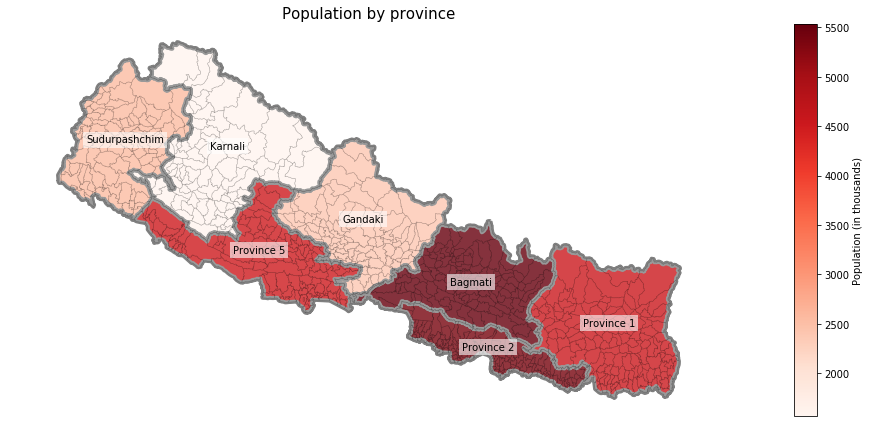

In [5]:
# Map 1 

fig, ax = plt.subplots(1, figsize=(15,10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.5)

nepal_province.plot(ax=ax,
                    column=nepal_province.Population/1000,
                    linewidth=4, 
                    edgecolor='grey',
                    cmap = 'Reds',
                    k=5, 
                    legend=True,
                    cax=cax,
                    legend_kwds=dict(label = "Population (in thousands)")
                   )

nepal_province.apply(lambda x: ax.annotate(s=x.Name, 
                                           xy=x.geometry.centroid.coords[0], 
                                           ha='center', 
                                           va='center',
                                           bbox=dict(boxstyle="square", 
                                                     fc="w", 
                                                     edgecolor='none', 
                                                     facecolor ='white', 
                                                     alpha=0.6)
                                          ),axis=1);

nepal_local.plot(ax=ax,
                 #column=nepal_local.Population,
                 linewidth=0.5, 
                 edgecolor='black',
                 #cmap='inferno',
                 color='white', 
                 alpha=0.2)

ax.set_axis_off()

ax.set_title("Population by province", 
             fontdict={'fontsize': 15, 'fontweight': 'medium'});


In [6]:
# Final map: Share in total tax collection (%)

latitude = 28.3949
longitude = 84.1240

m = folium.Map(location=[latitude, longitude], zoom_start=7.45, tiles="cartodbpositron")

nepal_province['Contrib'] = nepal_province['Contrib'].round(decimals=1)

# Tax contribution

choropleth  = folium.Choropleth(
     geo_data = nepal_province,
     key_on = 'feature.properties.Name',
     data = nepal_province,
     columns = ['Name','Contrib'],
     bins=[0, 5, 10, 20, 40, 60, 80],
     fill_color = 'RdPu',
     highlight = True,
     legend_name = 'Share in total tax collection (%)',
     name='Tax collection'
    ).add_to(m)

# Square with name and value when putting the mouse on top

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields=['Name', 'Contrib', 'Offices', 'Population', 'GDP_pc'],
        aliases=['Province', 'Share of tax collection (%)', 'Offices', 'Population', 'GDP per capita'],
        style=('background-color: grey; color: white;'),
        localize = True,
        )
    )


# Remove comment below to show map
# m




In [7]:
# Final map: Number of tax offices

m = folium.Map(location=[latitude, longitude], zoom_start=7.45, tiles="cartodbpositron")

# Tax contribution

choropleth  = folium.Choropleth(
     geo_data = nepal_province,
     key_on = 'feature.properties.Name',
     data = nepal_province,
     columns = ['Name','Offices'],
     bins=[0, 5, 10, 15, 20, 25],
     fill_color = 'YlGn',
     highlight = True,
     legend_name = 'Number of tax offices',
     name='Offices'
    ).add_to(m)

# Square with name and value when putting the mouse on top

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields=['Name', 'Contrib', 'Offices', 'Population', 'GDP_pc'],
        aliases=['Province', 'Share of tax collection (%)', 'Offices', 'Population', 'GDP per capita'],
        style=('background-color: grey; color: white;'),
        localize = True,
        )
    )

# Remove comment below to show map
# m

## Municipalities

### Dataset

In [8]:
municipalities = pd.read_excel(r'Municipalities.xlsx')

municipalities = municipalities[['Province', 
                                 'District', 
                                 'Municipality', 
                                 'ADM2_PCODE',                         
                                 'Total', 
                                 'conditional_complementary_share_gov',
                                 'conditional_complementary_share_prov',
                                 'conditional_complementary_share_total',
                                 'pop',
                                 'area',
                                 'density'
                                ]]

municipalities.head(3)


,Province,District,Municipality,ADM2_PCODE,Total,conditional_complementary_share_gov,conditional_complementary_share_prov,conditional_complementary_share_total,pop,area,density
0,Province 1,Bhojpur,Aamchowk Rural Municipality,NP0110406,3.129959e+08,0.526457,0.867341,0.465230,18720,184.89,101.249392
1,Province 1,Bhojpur,Arun Rural Municipality,NP0110403,3.432870e+08,0.533210,0.740355,0.414636,17687,154.76,114.286637
2,Province 1,Bhojpur,Bhojpur Municipality,NP0110302,4.772344e+08,0.568121,0.886405,0.498992,27204,159.51,170.547301


In [9]:
# Merge dataset with geographical data

nepal_local_geo = nepal_local[["ADM2_PCODE", "geometry"]]
municipalities_merged = pd.merge(nepal_local_geo, municipalities, on=['ADM2_PCODE'], how='outer')
avg = np.log(municipalities_merged['density'].mean())
municipalities_merged['density_log'] = np.log(municipalities_merged['density']) - avg
municipalities_merged['pop'] = municipalities_merged['pop'].astype(float)
municipalities_merged.head(3)

,ADM2_PCODE,geometry,Province,District,Municipality,Total,conditional_complementary_share_gov,conditional_complementary_share_prov,conditional_complementary_share_total,pop,area,density,density_log
0,NP0110406,"POLYGON ((86.96819 27.05014, 86.96847 27.04968...",Province 1,Bhojpur,Aamchowk Rural Municipality,3.129959e+08,0.526457,0.867341,0.465230,18720.0,184.89,101.249392,-1.445171
1,NP0441401,"POLYGON ((83.80659 28.21951, 83.80678 28.21945...",Gandaki,Syangja,Aandhikhola Rural Municipality,3.588422e+08,0.599948,0.072148,0.512088,16589.0,69.61,238.313461,-0.589171
2,NP0436406,"POLYGON ((84.95063 28.19931, 84.95150 28.19913...",Gandaki,Gorkha,Aarughat Rural Municipality,4.823081e+08,0.419122,0.000000,0.304778,23887.0,160.79,148.560234,-1.061767


In [10]:
# Rectangle
grid_pt=(28,84)
W=grid_pt[1]-4.12
E=grid_pt[1]+4.32
N=grid_pt[0]+2.58
S=grid_pt[0]-1.79

upper_left=(N,W)
upper_right=(N,E)
lower_right=(S,E)
lower_left=(S,W)

edges = [upper_left, upper_right, lower_right, lower_left]

# Map locations
latitude = 27.86
longitude = 83.2


### Population density map

In [11]:
m = folium.Map(location=[latitude, longitude], zoom_start=7.45, tiles="cartodbpositron")

choropleth  = folium.Choropleth(
     geo_data = municipalities_merged,
     data = municipalities_merged,
     key_on = 'feature.properties.ADM2_PCODE',
     columns = ['ADM2_PCODE','density_log'],
     bins=[-9, -5, -3, -2, -1, 0, 1, 2, 3, 5],
     fill_color = 'PuOr_r',
     highlight = True,
     legend_name = '(Log of population density) - (Log of mean population density)',
     name='Population density per municipality'
    ).add_to(m)

folium.GeoJson(nepal_province.to_json(),
                style_function=lambda x: {'width':8, 'color':'black', 'fillColor':'none'}
              ).add_to(m)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields=['Municipality', 'District', 'Province', 'pop', 'density'],
        aliases=['Municipality', 'District', 'Province', 'Population', 'Population density'],
        style=('background-color: grey; color: white;'),
        localize = True,
        )
    )

folium.Rectangle(bounds=edges, color='Black', fill=False).add_to(m)

# Remove comment below to show map
# m


### Conditional transfers to municipalities

In [12]:
m = folium.Map(location=[latitude, longitude], zoom_start=7.45, tiles="cartodbpositron")

choropleth  = folium.Choropleth(
     geo_data = municipalities_merged,
     data = municipalities_merged,
     key_on = 'feature.properties.ADM2_PCODE',
     columns = ['ADM2_PCODE','conditional_complementary_share_total'],
     bins=[0, 0.2, 0.4, 0.6, 0.8, 1],
     fill_color = 'YlGn',
     highlight = True,
     legend_name = 'Share of revenue that is either conditional or complementary',
     name='Share of revenue that is either conditional or complementary'
    ).add_to(m)

folium.GeoJson(nepal_province.to_json(),
                style_function=lambda x: {'width':8, 'color':'black', 'fillColor':'none'}
              ).add_to(m)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields=['Municipality', 'District', 'Province', 'pop', 'conditional_complementary_share_total'],
        aliases=['Municipality', 'District', 'Province', 'Population', 'Share'],
        style=('background-color: grey; color: white;'),
        localize = True,
        )
    )

folium.Rectangle(bounds=edges, color='Black', fill=False).add_to(m)

# Remove comment below to show map
# m

### Conditional government transfers to municipalities

In [13]:
m = folium.Map(location=[latitude, longitude], zoom_start=7.45, tiles="cartodbpositron")

choropleth  = folium.Choropleth(
     geo_data = municipalities_merged,
     data = municipalities_merged,
     key_on = 'feature.properties.ADM2_PCODE',
     columns = ['ADM2_PCODE','conditional_complementary_share_gov'],
     bins=[0, 0.2, 0.4, 0.6, 0.8, 1],
     fill_color = 'YlOrRd',
     highlight = True,
     legend_name = 'Share of Central transfers that is either conditional or complementary',
     name='Share of government transfers that is either conditional or complementary'
    ).add_to(m)

folium.GeoJson(nepal_province.to_json(),
                style_function=lambda x: {'width':8, 'color':'black', 'fillColor':'none'}
              ).add_to(m)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields=['Municipality', 'District', 'Province', 'pop', 'conditional_complementary_share_gov'],
        aliases=['Municipality', 'District', 'Province', 'Population', 'Share'],
        style=('background-color: grey; color: white;'),
        localize = True,
        )
    )

folium.Rectangle(bounds=edges, color='Black', fill=False).add_to(m)

# Remove comment below to show map
# m

### Conditional province transfers to municipalities

In [14]:
m = folium.Map(location=[latitude, longitude], zoom_start=7.45, tiles="cartodbpositron")

choropleth  = folium.Choropleth(
     geo_data = municipalities_merged,
     data = municipalities_merged,
     key_on = 'feature.properties.ADM2_PCODE',
     columns = ['ADM2_PCODE','conditional_complementary_share_prov'],
     bins=[0, 0.2, 0.4, 0.6, 0.8, 1],
     fill_color = 'YlGnBu',
     highlight = True,
     legend_name = 'Share of province transfers that is either conditional or complementary',
     name='Share of province transfers that is either conditional or complementary'
    ).add_to(m)

folium.GeoJson(nepal_province.to_json(),
                style_function=lambda x: {'width':8, 'color':'black', 'fillColor':'none'}
              ).add_to(m)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields=['Municipality', 'District', 'Province', 'pop', 'conditional_complementary_share_prov'],
        aliases=['Municipality', 'District', 'Province', 'Population', 'Share'],
        style=('background-color: grey; color: white;'),
        localize = True,
        )
    )

folium.Rectangle(bounds=edges, color='Black', fill=False).add_to(m)

# Remove comment below to show map
# m

### Population by Municipality

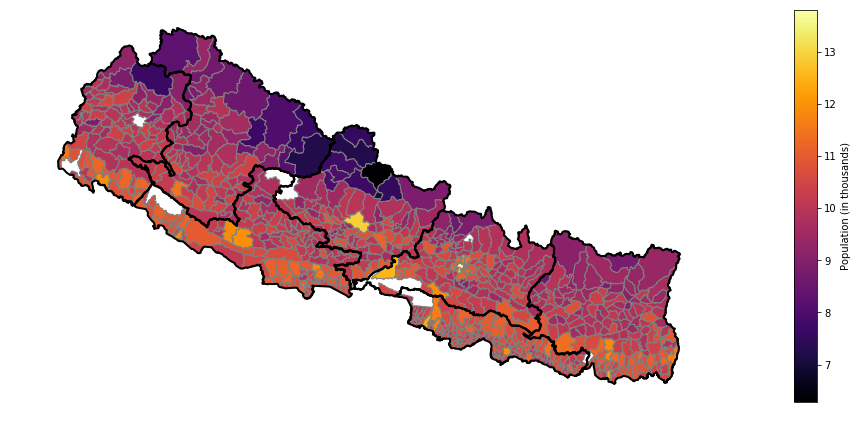

In [15]:
fig, ax = plt.subplots(1, figsize=(15,10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.5)


municipalities_merged.plot(ax=ax,
                    column=np.log(municipalities_merged['pop']),
                    linewidth=1, 
                    edgecolor='grey',
                    cmap = 'inferno',
                    k=5, 
                    legend=True,
                    cax=cax,
                    legend_kwds=dict(label = "Population (in thousands)")
                   )

# Remove comment to include labels on provinces
################################################################################
# nepal_province.apply(lambda x: ax.annotate(s=x.Name, 
#                                            xy=x.geometry.centroid.coords[0], 
#                                            ha='center', 
#                                            va='center',
#                                            bbox=dict(boxstyle="square", 
#                                                      fc="w", 
#                                                      edgecolor='none', 
#                                                      facecolor ='white', 
#                                                      alpha=0.6)
#                                           ),axis=1);
################################################################################


#To focus on Kathmandu
################################################################################
# xlim = ([85.19,  85.51])
# ylim = ([27.55,  27.85])
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
################################################################################

nepal_province.plot(ax=ax,
                 linewidth=2, 
                 edgecolor='black',
                 color='none') 

ax.set_axis_off()